In [ ]:
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y
# Notice: You might need to uncomment and install the pydotplus and graphviz libraries if you have not installed these before

### Get Data 

In [1]:
## Get datasets from local machine into Jupyter Pandas dataframe, check shape
import pandas as pd
import numpy as np
df_pt_full = pd.read_csv('/Users/dahailiu/Desktop/DM for Cancer /NLST dataset/participant.data.d100517.csv')
df_lc = pd.read_csv('/Users/dahailiu/Desktop/DM for Cancer /NLST dataset/Lung Cancer/lung_cancer.data.d100517.csv')
df_sctabn_full = pd.read_csv('/Users/dahailiu/Desktop/DM for Cancer /NLST dataset/Spiral CT Abnormalities/sct_abnormalities.data.d100517.csv')
print(df_pt_full.shape)
print(df_lc.shape)
print(df_sctabn_full.shape)
pd.set_option('display.max_columns', None)

/Users/dahailiu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (99,248,249) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(53452, 324)
(2150, 48)
(177487, 12)


### Dataset #1: patient dataset, df_pt

In [2]:
#### Trim dataset: Selecting only the people being CT scanned, and those has a record of Cancer vs. Non Cancer
## Select only CT scan
df_pt_ct = df_pt_full.loc[df_pt_full['rndgroup'] == 1]
## Select only people that has a record of cancer vs non cancer
df_pt = df_pt_ct.loc[df_pt_ct['conflc'].isin([1,2])]
print('Shape of this datset:', df_pt.shape)
## This will trim the patient dataset df_pt into 6379 rows, from the original of 53452 rows
## summarize the cancer/Non-cancer count in pt dataset
conflc_counts = df_pt['conflc'].value_counts().to_frame()
conflc_counts.rename(columns={'conflc': 'Number of patient'}, inplace=True)
conflc_counts.index.name = 'conflc'
conflc_counts
# 1089 with cancer, and 5290 without cancer

Shape of this datset: (6379, 324)


,Number of patient
conflc,
2,5290
1,1089


### Dataset #3 -Sct_abnormality: df_sctabn and its trim

In [3]:
## Select in abnormality only the rows that has sct_ab_desc in 51,52,53,62

df_abn_bigsmallnomany = df_sctabn_full.loc[df_sctabn_full['sct_ab_desc'].isin([51,52,53,62])]

## select columns in abnormality dataset that's only useful for the research
df_abn_useful = df_abn_bigsmallnomany[['dataset_version','pid','sct_ab_desc','sct_ab_num', 'sct_epi_loc',
                                       'sct_long_dia','sct_slice_num','study_yr']] 
df_abn_useful.shape

(81356, 8)

In [7]:
## Calculation of largest nodule, total nodule size, number of nodule
df_abn_agg = df_abn_useful[['pid','sct_long_dia','study_yr']]
df_abn_nodulesum =    df_abn_agg.groupby(['pid'], as_index = False).sum()
df_abn_nodulemax =    df_abn_agg.groupby(['pid'], as_index = False).max()
df_abn_nodulecounts = df_abn_agg.groupby(['pid'], as_index = False).count()
## 81,356 record will become 19,116 after picking the sum/max/count with one pid only appear once
## Renaming the 3 data frames with each of their 'sct_long_dia' columns to indicate it's a sum, max, or a count
df_abn_nodulesum.rename(columns={'sct_long_dia': 'sct_long_dia_sum'}, inplace=True)
df_abn_nodulemax.rename(columns={'sct_long_dia': 'sct_long_dia_max'}, inplace=True)
df_abn_nodulecounts.rename(columns={'sct_long_dia': 'sct_long_dia_count'}, inplace=True)

## Problem: I'm only looking at nodules that are > 4mm. But I did not look at small nodules. 

### Joining #1 df_pt with #3 df_sct_abn

In [8]:
## 辣鸡代码效率可以提高
df_pt_abn_sum = pd.merge(df_pt, df_abn_nodulesum, how='left', left_on='pid', right_on='pid')
df_pt_abn_sum_max = pd.merge(df_pt_abn_sum, df_abn_nodulemax, how='left', left_on='pid', right_on='pid')
df_pt_abn_sum_max_counts = pd.merge(df_pt_abn_sum_max, df_abn_nodulecounts, how='left', left_on='pid', right_on='pid')
df_pt_abn_sum_max_counts.shape
## From here, the pt dataset is combined with abnormal dataset, with nodules size info, that contains max/sum/counts
## The N match exactly what has been discussed, which is 6379 patients has a record of Cancer/No Cancer
## Surprisingly, and happlily, the N=6379 has not been decreased by joining the abn dataset with sct_ab_desc in (51, 52, 53, 62)

(6379, 330)

### Assembling Table 1:

In [9]:
## Building table 1 for the first model(this we only use dataset pt, and CT, but not lc)
## Based on literature review of Jinglu's code, and meeting discussions on Dec. 6, 
## We select following variables for analysis: literature review, occupational hazard, athma, #cigar smoked, current smoker

df_pt_abn = df_pt_abn_sum_max_counts[['pid', 'age','gender', 'smokelive','race','pkyr','smokework',
                                      'famfather','fammother','anyscr_has_nodule','conflc', 'sct_long_dia_sum'
                                      ,'sct_long_dia_max', 'sct_long_dia_count','study_yr','diagcopd'
                                      # Add in occupational hazard
                                      ,'wrkasbe','wrkbaki','wrkbutc','wrkchem','wrkcoal','wrkcott','wrkfarm'
                                      ,'wrkfire', 'wrkflou', 'wrkfoun','wrkhard','wrkpain','wrksand','wrkweld'
                                      # Add in other: cigsmok current or former(quit 15 years)
                                      , 'cigsmok', 'diagadas','smokeday','marital']]

## Did Jinglu use max, sum or count??? Which COPD is important?? 
print('The shape of the final dataset is: ',df_pt_abn.shape)

print('How many missing values in each columns?', '\n', df_pt_abn.isnull().sum())

The shape of the final dataset is:  (6379, 34)
How many missing values in each columns? 
 pid                     0
age                     0
gender                  0
smokelive              34
race                    0
pkyr                    0
smokework              58
famfather             160
fammother             139
anyscr_has_nodule      15
conflc                  0
sct_long_dia_sum      171
sct_long_dia_max      411
sct_long_dia_count    171
study_yr              171
diagcopd               10
wrkasbe                 7
wrkbaki                 6
wrkbutc                 6
wrkchem                 6
wrkcoal                 6
wrkcott                 7
wrkfarm                 7
wrkfire                 6
wrkflou                 6
wrkfoun                 6
wrkhard                 6
wrkpain                 6
wrksand                 6
wrkweld                 6
cigsmok                 0
diagadas                8
smokeday                0
marital                 6
dtype: int64


In [10]:
#### Dec. 31, Collaps multiple variables into one
## On Dec. 31, sum up the value of 13 occupational hazard variables into one, except for wrkasbe for asbestos is particularly cancer-causing than other variables
df_pt_abn['wrk_total']= df_pt_abn.loc[:, ['wrkbaki','wrkbutc','wrkchem','wrkcoal','wrkcott','wrkfarm',
           'wrkfire', 'wrkflou', 'wrkfoun','wrkhard','wrkpain','wrksand',
           'wrkweld']].sum(axis=1)
## I not only wanted the sum, but also need a binary variable indicating 'have worked in hazardous job or not'
df_pt_abn['wrk_or_not'] = np.where(df_pt_abn['wrk_total']!=0, 1, 0)

df_pt_abn.head()

/Users/dahailiu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/dahailiu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,pid,age,gender,smokelive,race,pkyr,smokework,famfather,fammother,anyscr_has_nodule,conflc,sct_long_dia_sum,sct_long_dia_max,sct_long_dia_count,study_yr,diagcopd,wrkasbe,wrkbaki,wrkbutc,wrkchem,wrkcoal,wrkcott,wrkfarm,wrkfire,wrkflou,wrkfoun,wrkhard,wrkpain,wrksand,wrkweld,cigsmok,diagadas,smokeday,marital,wrk_total,wrk_or_not
0,100004,60,1,0.0,1,34.0,1.0,0.0,0.0,1.0,2,8.0,4.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0.0,40,2.0,4.0,1
1,100012,61,2,1.0,1,37.0,1.0,NaN,NaN,1.0,1,23.0,15.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,20,2.0,0.0,0
2,100019,61,1,0.0,1,78.0,1.0,0.0,0.0,1.0,2,14.0,14.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,40,2.0,0.0,0
3,100026,57,1,1.0,1,61.5,1.0,0.0,0.0,1.0,2,17.0,5.0,4.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0.0,30,2.0,1.0,1
4,100035,55,2,1.0,1,38.0,1.0,0.0,0.0,1.0,2,15.0,5.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,20,2.0,0.0,0


In [11]:
#### Create new variable for marital_status
## Define how to label
def label_marital (row):
    if row['marital'] == 1:
        return '1'
    if row['marital'] == 2:
        return '2'
    if row['marital'] in([3,4,5]):
        return '3'
    else: 
        return '0'
df_pt_abn['Marital_Status'] = df_pt_abn.apply (lambda row: label_marital (row),axis=1)
df_pt_abn.shape
# M="Missing"
# 1="Never married"
# 2="Married or living as married" 3="Widowed"
# 4="Separated"
# 5="Divorced"
# 7="Participant refused to answer" 9="Not Ascertained"

/Users/dahailiu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


(6379, 37)

In [12]:
## Drop all rows that has missing data
df_pt_abn = df_pt_abn.dropna()
df_pt_abn.shape

(5757, 37)

In [13]:
## Correcting Data Types for modeling purpose
df_pt_abn['gender'] = df_pt_abn['gender'].astype('object')
df_pt_abn['smokelive'] = df_pt_abn['smokelive'].astype('object')
df_pt_abn['race'] = df_pt_abn['race'].astype('object')
df_pt_abn['smokework'] = df_pt_abn['smokework'].astype('object')
df_pt_abn['famfather'] = df_pt_abn['famfather'].astype('object')
df_pt_abn['fammother'] = df_pt_abn['fammother'].astype('object')
df_pt_abn['anyscr_has_nodule'] = df_pt_abn['anyscr_has_nodule'].astype('object')
df_pt_abn['conflc'] = df_pt_abn['conflc'].astype('int')
df_pt_abn['study_yr'] = df_pt_abn['study_yr'].astype('object')
df_pt_abn['diagcopd'] = df_pt_abn['diagcopd'].astype('object')
## COPD is explained Dec.6
df_pt_abn['pkyr'] = df_pt_abn['pkyr'].astype('float32')
df_pt_abn['sct_long_dia_sum'] = df_pt_abn['sct_long_dia_sum'].astype('float32')
df_pt_abn['sct_long_dia_max'] = df_pt_abn['sct_long_dia_max'].astype('float32')
df_pt_abn['sct_long_dia_count'] = df_pt_abn['sct_long_dia_count'].astype('float32')
df_pt_abn['pid'] = df_pt_abn['pid'].astype('int32')
df_pt_abn['age'] = df_pt_abn['age'].astype('int32')
df_pt_abn.dtypes
## Need to also do this for new variables

pid                     int32
age                     int32
gender                 object
smokelive              object
race                   object
pkyr                  float32
smokework              object
famfather              object
fammother              object
anyscr_has_nodule      object
conflc                  int64
sct_long_dia_sum      float32
sct_long_dia_max      float32
sct_long_dia_count    float32
study_yr               object
diagcopd               object
wrkasbe               float64
wrkbaki               float64
wrkbutc               float64
wrkchem               float64
wrkcoal               float64
wrkcott               float64
wrkfarm               float64
wrkfire               float64
wrkflou               float64
wrkfoun               float64
wrkhard               float64
wrkpain               float64
wrksand               float64
wrkweld               float64
cigsmok                 int64
diagadas              float64
smokeday                int64
marital   

### Data Examination

In [14]:
a = list(['gender', 'smokelive','race','smokework','famfather','fammother','anyscr_has_nodule','conflc',
          'sct_long_dia_max', 'sct_long_dia_count','study_yr','diagcopd',
          ## Here I added in three varibles created in Dec. 31 that are occupational hazard related
          'wrkasbe','wrk_total','wrk_or_not',
          'cigsmok', 'diagadas','smokeday','Marital_Status'
         ])
for column in a:
    print(df_pt_abn[column].value_counts())
    print('                              ')

1    3459
2    2298
Name: gender, dtype: int64
                              
1.0    5046
0.0     711
Name: smokelive, dtype: int64
                              
1     5302
2      182
3      149
6       78
5       24
4       15
7        4
99       1
98       1
96       1
Name: race, dtype: int64
                              
1.0    4877
0.0     880
Name: smokework, dtype: int64
                              
0.0    5167
1.0     590
Name: famfather, dtype: int64
                              
0.0    5418
1.0     339
Name: fammother, dtype: int64
                              
1.0    5757
Name: anyscr_has_nodule, dtype: int64
                              
2    4959
1     798
Name: conflc, dtype: int64
                              
5.0      1079
6.0       855
4.0       721
7.0       648
8.0       482
10.0      305
9.0       302
11.0      182
12.0      163
13.0      136
15.0      108
14.0       96
17.0       79
16.0       75
18.0       66
20.0       53
19.0       46
24.0       30
28.0 

In [ ]:
export_path = '/Users/dahailiu/Downloads/20181127_1226.csv'
#df_pt_abn.to_csv(export_path)

## Machine Learning starts here:

In [15]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

### (Here is how Jinglu measured 3 times of feature importance, which will inform feature selection)

In [16]:
## Train-Test Split
df_pt_abn = df_pt_abn.reset_index()
from sklearn.model_selection import train_test_split
X = df_pt_abn [[ 'age','gender', 'smokelive','race','pkyr','smokework',
                                      'famfather','fammother','anyscr_has_nodule', 'sct_long_dia_sum'
                                      ,'sct_long_dia_max', 'sct_long_dia_count','diagcopd'
                # Added occupational hazard factors
                                      , 'wrkasbe','wrk_total','wrk_or_not'
                # Add asthma and smoking factors
                                      , 'diagadas','cigsmok','smokeday','Marital_Status']]
y = df_pt_abn ['conflc']
y = y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
## Random_state is the"set seed" in Python

In [17]:
## Fit a decision Tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
tree2 = DecisionTreeClassifier(max_depth = 4, criterion="entropy").fit(X_train, y_train)
print(tree2.score(X_test, y_test))
print(tree2)

0.8694444444444445
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [18]:
## Plotting Decision Tree
lpy = [item for item in X_train.columns]
import pydot_ng as pydot
from IPython.display import IFrame
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
with open("dt.dot","w") as dot_data:
    export_graphviz(tree2, out_file=dot_data, filled=True, 
                feature_names = lpy,label = 'all')
pydot.graph_from_dot_file("dt.dot").write_png("dt.png")
IFrame("dt.png", width = 1000, height = 500)

### Work undone: Plotting Feature Importance??

### GBDT

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
GBDT = GradientBoostingClassifier(learning_rate = .1, max_depth = 4, random_state = 0)
gbdt = GBDT.fit(X_train, y_train)
gbdt.score(X_test, y_test)

0.8673611111111111

In [20]:
## Confusion Matrics for Gradient Boosted Decision Tree
from sklearn.metrics import confusion_matrix
gbdt_predicted = gbdt.predict(X_test)
confusion_gbdt = confusion_matrix(y_test, gbdt_predicted)
print('gradient boost decision tree classifier',  confusion_gbdt)

gradient boost decision tree classifier [[  52  147]
 [  44 1197]]


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall) 
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, gbdt_predicted)))
print('Precision, which matters more: {:.2f}'.format(precision_score(y_test, gbdt_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test, gbdt_predicted)))
print('F1: {:.2f}'.format(f1_score(y_test, gbdt_predicted)))

Accuracy: 0.87
Precision, which matters more: 0.54
Recall: 0.26
F1: 0.35


### Support Vector Machine

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
# we must apply the scaling to the test set that we computed for the training set
X_test_scaled = scaler.transform(X_test)

/Users/dahailiu/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float32, int32, float64, object were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [23]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_scaled, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train_scaled, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test_scaled, y_test)))

Accuracy of K-NN classifier on training set: 0.88
Accuracy of K-NN classifier on test set: 0.86


In [24]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

clf = SVC().fit(X_train, y_train)
print('Cancer dataset')
print('Accuracy of Linear SVC classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Linear SVC classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

/Users/dahailiu/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Cancer dataset
Accuracy of Linear SVC classifier on training set: 0.94
Accuracy of Linear SVC classifier on test set: 0.86


In [25]:
from sklearn.model_selection import validation_curve
param_range = np.logspace(-3, 3, 4)
train_scores, test_scores = validation_curve(SVC(), X, y,
                                            param_name='gamma',
                                            param_range=param_range, cv=3)

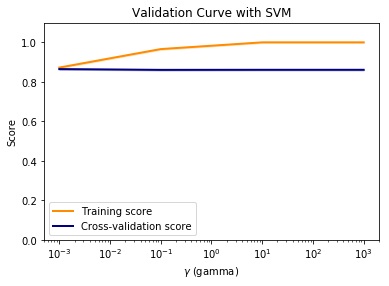

In [26]:
# This code based on scikit-learn validation_plot example
#  See:  http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html
import matplotlib.pyplot as plt
plt.figure()

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Validation Curve with SVM')
plt.xlabel('$\gamma$ (gamma)')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)
lw = 2

plt.semilogx(param_range, train_scores_mean, label='Training score',
            color='darkorange', lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.2,
                color='darkorange', lw=lw)

plt.semilogx(param_range, test_scores_mean, label='Cross-validation score',
            color='navy', lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.2,
                color='navy', lw=lw)

plt.legend(loc='best')


plt.show()

### Plotting ROC Curve

In [27]:
## Plotting ROC Curves 这个会报错啊啊啊啊啊啊啊！！！！！
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_score_gbdt = gbdt.decision_function(X_test)
fpr_gbdt, tpr_gbdt, _ = roc_curve(y_test, y_score_gbdt)
roc_auc_gbdt = auc(fpr_gbdt, tpr_gbdt)
plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_gbdt, tpr_gbdt, lw=3, label='GBDT ROC curve (area = {:0.2f})'.format(roc_auc_gbdt))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

ValueError: Data is not binary and pos_label is not specified

# Comments

# Keep some distance! Here's about the 3rd dataset

In [ ]:
#Attribute usage:
# 100.00% RaceCategory #100.00% Ethnicity
#100.00% PackYears
#99.99% Age
#99.51% FamilyHxFather #99.34% Sex
#99.25% FamilyHxMother #98.57% SmokingNowCategory


# 100.00% Ethnicity #100.00% PackYears
#99.71% Age
#97.78% RaceCategory 
#84.81% FamilyHxMother 
#80.36% SmokingNowCategory 
#74.82% SecondSmokeAtHome 
#72.75% FamilyHxFather #64.44% Sex

#MeanDecreaseGini
#Age 1335.7826
#Sex 201.7961
#PackYears 1963.1295
#AbnormalCTdiametersize 916.6168
#AbnormalCTnumberofsuspiciousmasses 703.6684
#AbnormalCTtype   0.0000
#RaceCategory 293.6279
#EthnicityCategory 104.7826
#FamilyHxFather 186.8981
#FamilyHxMother 169.8810
#SecondSmokeAtHome 219.8933
#SecondSmokeAtWork 167.0132
#SmokingNowCategory 204.0901